# Full Pipeline for PeakyFinder
## load full NIST database, create spectra, generate training data, train model, test model

### Michael L. Whittaker & Matt Goff
### 10-27-2022

### Import libraries

In [1]:
import os
import re
import sys
import math
import pickle
import datetime
import requests
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.special import voigt_profile as voigt

### Set paths

In [2]:
rel_path = 'PeakyFinder/' 
top_dir = Path.cwd().parent
datapath = top_dir / rel_path

### Scrape NIST database

In [5]:
el_list = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 
            'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs',
             'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 
             'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 
             'Ds', 'Rg', 'Cn', 'Uut', 'Fl', 'Uup', 'Lv', 'Uus', 'Uuo']

def get_lines(element):
    """ get spectral line data from NIST LIBS lines database 
        args:
            element (str): One, Two or Three character element name (e.g., 'O', 'Si', 'Uuo')
        returns:
            data_array (numpy array): All LIBS line data available for a given element
    """
    
    url_el = "https://physics.nist.gov/cgi-bin/ASD/lines1.pl?spectra=" + str(element) + "&limits_type=0&low_w=0&upp_w=2000&unit=1&submit=Retrieve+Data&de=0&format=3&line_out=1&remove_js=on&no_spaces=on&en_unit=1&output=0&bibrefs=1&page_size=15&show_obs_wl=1&show_calc_wl=1&order_out=0&max_low_enrg=&show_av=3&max_upp_enrg=&tsb_value=0&min_str=&A_out=1&intens_out=on&max_str=&allowed_out=1&forbid_out=1&min_accur=&min_intens=&conf_out=on&term_out=on&enrg_out=on&J_out=on&g_out=on"
    response = requests.get(url_el)
    data = response.text
    data = data.split('\n')
    data_array =[]
    for d in data[:-1]: # last element in list is blank - leave it off
        d = d.split('\t')
        data_array.append(d)
    
    data_array = np.array(data_array)

    return data_array

def all_lines(els, path, overwrite=True):
    """ save LIBS data corresponding to all elements 'els' to 'path'
        one file for each elmement of 'els'
        args:
            els (list): list of One, Two or Three character element names (e.g., 'O', 'Si', 'Uuo')
            path (str): path to which pickle files will be saved
            overwrite (bool): default = True. Whether to overwrite existing pickle files
    """
    if overwrite==False:
    # --- find elements for which data already exists and exclude them from processing
        import glob
        el_in = [i.split('.')[0].split('/')[-1] for i in sorted(glob.glob(path + "*.pickle"))]
        d = {k:v for v,k in enumerate(els)}
        pos_in = [*(d[k] for k in el_in)]
    
    #  Pickle the lines database with default protocol (4 as of py3.8)
    fail_list = []
    for el in els:
        try:
            db_path = path + str(el) + '.pickle'
            with open(db_path, 'wb') as f:
                data = get_lines(el)
                pickle.dump(data, f)
        except:
            print("Element " + str(el) + " did not pickle properly")
            fail_list.append(el)
  
    with open(path + 'failed.txt', 'wb') as g:
            data = get_lines(el)
            pickle.dump(data, g)

# run this to re-scrape data for specific elements
all_lines(el_list, "/Users/mwhittaker/Projects/PeakyFinder/database/")

/var/folders/yj/sjr_202x2fvfp9wq2lrrdf0h0000gn/T/ipykernel_80263/4191035386.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_array = np.array(data_array)


### Pre-process database to dictionary with element key

In [6]:
files = (datapath / 'database').glob('*.pickle')
atom_dict = {} 

#Available elements
el_include = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 
            'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs',
             'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 
             'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U']

#NIST database missing data for these elements
no_lines = ['Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 
             'Ds', 'Rg', 'Cn', 'Uut', 'Fl', 'Uup', 'Lv', 'Uus', 'Uuo'] 

#Loop over each element to import data, parse strings, clean up unwanted characters, and pickle the result
for file in files:
    m = re.search('([A-Za-z]+).pickle$', file.name) #get element name from filename
    element = m[1]
    
    if element in no_lines or element not in el_include: #check for elements that don't belong
        print('Skipping: ', element)
        continue
    
    #load file data into ndarray and keep only useful columns
    filedata = np.load(file, allow_pickle=True)
    col_names = filedata[0]
    col_keep = ['sp_num', 'ritz_wl_vac(nm)', 'intens', 'gA(s^-1)', 'Ei(eV)', 'Ek(eV)','conf_i', 'term_i', 'J_i', 'conf_k', 'term_k', 'J_k', 'g_i', 'g_k'] # 14 total columns
    cols = [i in col_keep for i in col_names]
    cols_not = [i not in col_names for i in col_keep]
    if len(col_keep) > len(cols):
        print(element + ' has missing columns: ' + str(cols_not))
    filedata = filedata[:, cols] #keep desired columns
    
    #string parsing to remove entries with spurrious characters in database
    for i in range(1,filedata.shape[0]):
        if element == 'H': # hydrogen is special (no possible i+1 lines, so it is missing the first sp_num column)
            if filedata.shape[-1] == 13:
                newcol = np.ones(filedata.shape[0])[..., None]
                filedata = np.append(newcol,filedata,1)
        if any([re.search('[0-9]+.[0-9]+', j) for j in filedata[i]]): #look for `+` signs in the wavelength (second) column
            filedata[i,1] = filedata[i,1].replace('+','')
        if any([re.search('\*', j) for j in filedata[i]]): #look for `*` signs and remove them
            filedata[i,1] = filedata[i,1].replace('*','')
            filedata[i,2] = filedata[i,2].replace('*','')
            filedata[i,3] = filedata[i,3].replace('*','')
            filedata[i,7] = filedata[i,7].replace('*','')
        if any([re.search(':', j) for j in filedata[i]]): #look for `:` signs and remove them
            filedata[i,2] = filedata[i,2].replace(':','')
        if any([re.search('"', j) for j in filedata[i]]): #look for `"` signs and remove them
            filedata[i,1] = filedata[i,1].replace('"','')
            filedata[i,2] = filedata[i,2].replace('"','')
            filedata[i,3] = filedata[i,3].replace('"','')
            filedata[i,4] = filedata[i,4].replace('"','')
            filedata[i,5] = filedata[i,5].replace('"','')
        
    if len(filedata) == 0:
        no_lines.append(element) #relegate elements with no useful data to the no_lines list
    else:
        rep = ' -,":?[]()+&;abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
        for r in rep: #this is bad and slow but only has to happen once ... hopefully
            filedata[:,2] = np.array([str(i).replace(r,'') for i in filedata[:,2]])
            filedata[:,4] = np.array([str(i).replace(r,'') for i in filedata[:,4]])
            filedata[:,5] = np.array([str(i).replace(r,'') for i in filedata[:,5]])
        filedata[filedata == ''] = 0
        filedata[filedata == '""'] = 0
        atom_dict[element] = np.column_stack((filedata[1:,0].astype(float),
                                                filedata[1:,1].astype(float),
                                                filedata[1:,2].astype(float),
                                                filedata[1:,3].astype(float),
                                                filedata[1:,4].astype(float),
                                                filedata[1:,5].astype(float),
                                                filedata[1:,6],
                                                filedata[1:,7],
                                                filedata[1:,8],
                                                filedata[1:,9],
                                                filedata[1:,10],
                                                filedata[1:,11],
                                                filedata[1:,12],
                                                filedata[1:,13]))
        
        delzero = atom_dict[element][:,1].astype(float) == 0.0
        atom_dict[element] = atom_dict[element][~delzero]
        
print('no lines for: ' + str(np.sort(no_lines)))
print('valid elements: ' + str(len(atom_dict)))

#persist the data for ongoing usage
lines_path = 'rel_int/el_lines' + str(len(atom_dict)) + '.pickle'
nolines_path = 'rel_int/no_lines' + str(len(no_lines)) + '.pickle'
with open(datapath / lines_path, 'wb') as f:
    pickle.dump(atom_dict, f) #Pickle the relative intensity spectra with default protocol (4 as of py3.8)
with open(datapath / nolines_path, 'wb') as g:
    pickle.dump(no_lines, g) #Pickle the no_lines list in case it is of use

Skipping:  Uuo
Skipping:  Bh
Skipping:  Cf
Skipping:  Ds
Skipping:  No
Skipping:  Es
Skipping:  Fm
Skipping:  Rg
Skipping:  Sg
Skipping:  Uus
Skipping:  Pu
Skipping:  Cn
Skipping:  Uut
Skipping:  Fl
Skipping:  Am
Skipping:  Bk
Skipping:  Lr
Skipping:  Md
Skipping:  Cm
Skipping:  Rf
Skipping:  Uup
Skipping:  Lv
Skipping:  Mt
Skipping:  Np
Skipping:  Hs
Skipping:  Db
no lines for: ['Am' 'Bh' 'Bk' 'Cf' 'Cm' 'Cn' 'Db' 'Ds' 'Es' 'Fl' 'Fm' 'Hs' 'Lr' 'Lv'
 'Md' 'Mt' 'No' 'Np' 'Pu' 'Rf' 'Rg' 'Sg' 'Uuo' 'Uup' 'Uus' 'Uut']
valid elements: 92


## PeakyMaker

In [3]:
class spectrum_maker():
    #class docstring, parameters, public methods
    """ generates LIBS spectra """
    #class attributes
    def __init__(self) -> None:
        self.elem = ['H', 'He', #row1
                    'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', #row2
                    'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', #row3
                    'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', #row4
                    'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', #row5
                    'Cs', 'Ba', #row6 alkali/alkaline earth
                    'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', #row6 rare earths
                    'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', #row6 transition metals
                    'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U'] #row 7 stable elements

        #database missing data for these elements
        with open(datapath / "rel_int/no_lines26.pickle", 'rb') as f:
            self.no_lines = pickle.load(f)
        
        # double check that no_lines elements aren't in avail_el
        self.elements = [el for el in self.elem if el not in self.no_lines]
        self.max_z = len(self.elements)
        with open(datapath / "rel_int/el_lines92.pickle", 'rb') as f:
            self.atom_dict = pickle.load(f)

        #relative natural abundance of elements
        self.elem_abund = np.loadtxt(datapath / "abundance/abundance_92.csv")

    # Peak maker function
    def peak_maker(self,
                    element, #element symbol for which spectrum will be generated
                    inc=1/30, #spectral wavelength resolution, i.e., increment between datapoints (nm)
                    w_lo=180, #lower limit of wavelength range (nm)
                    w_hi=961+(1/30), #upper limit of wavelength range (nm) - need an extra `inc` here to span full range
                    voigt_sig=0.5, #stdev of normal part of voigt convolution
                    voigt_gam=0.5, #half-width at half max parameter of cauchy part of convolution
                    temp=12000, # K
                    ne=10**17, # cm**-3 - electron density
                    shift=False,
                    shift_type='random',
                    shift_mean=2,
                    height=False,
                    height_type='random',
                    height_mag=2,
                    plot=False):
        """peak_maker generates a single-element LIBS spectrum for `element`
            args:
                element (str) - element symbol for which spectrum will be generated
            kwargs:
                inc (float) - spectral wavelength resolution, i.e., increment between datapoints (nm)
                w_lo (float) - lower limit of wavelength range (nm)
                w_hi (float) - upper limit of wavelength range (nm)
                voigt_sig (float) - stdev of normal part of voigt peak profile
                voigt_gam (float) - half-width at half max parameter of cauchy part of convolution
                temp (float) - temperature of plasma from which LIBS spectrum for this element is generated in (K)
                ne (float) - number density of electrons in the plasma (cm**-3)
                shift (bool) - whether to apply a shift to peak positions
                shift_type (str) - 'random' applies a random shift to each peak; 'sys' applies a systematic shift
                height (bool) - whether to jitter peak heights
                height_type (str) - 'random' jitters peak heights randomly
                height_mag (float) - maximum magnitude by which to vary peak heights
                plot (bool) - whether to plot the resulting spetrum
        """
        # ['sp_num', 'ritz_wl_vac(nm)', 'intens', 'gA(s^-1)', 'Ei(eV)', 'Ek(eV)','conf_i', 'term_i', 'J_i', 'conf_k', 'term_k', 'J_k', 'g_i', 'g_k'] # 14 total columns
        ionization = self.atom_dict[element][:,0].astype(float)
        peak_loc = self.atom_dict[element][:,1].astype(float)
        intens = self.atom_dict[element][:,2].astype(float)
        gA = self.atom_dict[element][:,3].astype(float)
        Ei = self.atom_dict[element][:,4].astype(float)
        Ek = self.atom_dict[element][:,5].astype(float)
        gi = self.atom_dict[element][:,12].astype(float)
        gk = self.atom_dict[element][:,13].astype(float)
        wave = np.arange(w_lo, w_hi, inc)
        
        def saha_boltzmann(peak_loc, intens, gA, gi, gk, Ei, Ek, temp=temp):
            """ apply saha boltzmann equation for a given set of peaks associated with element specified in parent 'peak_maker' function
                 args:
                    peak_loc (float) - Ritz wavelength (in nm)
                    gA (float) - Einstein transition probability for k->i transition multiplied by degeneracy of level k
                    gi (float) - degeneracy of the lower level i
                    gk (float) - degeneracy of upper level k
                    del_E (float) - energy difference between levels
                    T (float) - temperature of plasma (defauls to specification in peak_maker parent function)
                returns:
                    peak intensities at each transition wavelength

                supporting information:
                    https://www.nist.gov/pml/atomic-spectroscopy-compendium-basic-ideas-notation-data-and-formulas/atomic-spectroscopy
                    eline = (1/4pi) * hc/l * Aki * Nk
                    h is Planck constant - 6.62607015 * 10**-34
                    l is photon wavelength
                    Aki is atomic transition probability from k to i
                    Nk is the number density of ions in the upper level k
                        Nk is given by Saha-Boltzmann equation
                        Nk = Ni/Ne * gk/gi * Exp [-dEki/kT]
                            Ne is the total electron density
                            Ni is the density in the ith state
                            gk and gi are degeneracies of the levels k and i, respectively
                            dEki is the energy difference between levels k and i, respectively
                            k is Boltzmann constant (8.617333262*10**5 eV/K)
                            # 1 eV = 8065.54445(69) cm**-1
            """

            # calculate the partition functions to determine ion densities
            k = 8.617333262*10**-5 # eV/K
            kT = k*temp
            c = 3*10**8
            states = np.sort(np.unique(ionization))
            Zind = []
            for i in states:
                idx = ionization == i
                Zind.append(idx)
            Zi = []
            for i in Zind:
                Zie = gk[i] * np.exp(-Ek[i]/(kT))
                Zisum = np.sum(Zie, axis=0)
                Zi.append(Zisum)
            Zi = np.array(Zi) 
            #Zvals = Zi > 10**-10

            loc = []
            spec = []
            for i, z in enumerate(Zind):
                saha_spec = (4*np.pi)**-1 * 6.62607015*10**-34 * c * 10**9 * (peak_loc[z]**-1) * gA[z] * Zi[i] * 10**6 * np.exp(-Ek[z]/kT)
                spec.append(saha_spec)
                loc.append(peak_loc[z])

            return loc, spec

        #create spectra from database parameters using Saha-Boltzmann equation
        x, y = saha_boltzmann(peak_loc, intens, gA, gi, gk, Ei, Ek)
        x = np.array([i for sub in x for i in sub]) #combine wavelengths from each ionization state into a single spectrum
        y = np.array([i for sub in y for i in sub]) #combine intensities from each ionization state into a single spectrum
        xlen = len(x)

        # jitter peak positions and intensities
        # this is in addition to peak intensity variation with T and ne in Saha-Boltzmann above
        if shift:
            if shift_type=='sys': #apply systematic peak shift - corresponds to shift in optics system temperature (lens/detector)
                x = x + shift_mean
            if shift=='random': #apply random wavelength shift
                mag = shift_mean * (np.random.rand(xlen) - 0.5)
                x = x + mag
        if height:
            if height_type=='random':
                h_mult = height_mag * np.random.rand(xlen)
                y = y * h_mult
        
        # create peaks with defined Voigt profiles from peak location and intensities derived from database
        peaks = np.array([yy * voigt(wave - xx, voigt_sig, voigt_gam) for xx, yy in zip(x, y)])
        spec = np.sum(peaks, axis=0)
        
        if plot:
            plt.plot(wave, spec)
            plt.xlabel('wavelength [nm]')
            plt.ylabel('intensity')
            plt.xlim([190, 950])
            plt.show
        
        return wave, spec    
    
   
    #make_spectra provides the weighted superposition of peak_maker spectra with artifacts/noise added
    def make_spectra(self, 
                    fracs, #relative element proportion array
                    
                    inc=1/30, #spectral wavelength resolution, i.e., increment between datapoints (nm)
                    w_lo=180, #lower limit of wavelength range (nm)
                    w_hi=961+(1/30), #upper limit of wavelength range (nm) - need an extra `inc` here to span full range
                    voigt_sig=0.5, #stdev of normal part of voigt convolution
                    voigt_gam=0.5, #half-width at half max parameter of cauchy part of convolution
                    temp=12000, # K
                    ne=10**17, # cm**-3 - electron density
                    shift=False,
                    shift_type='random',
                    shift_mean=2,
                    height=False,
                    height_type='random',
                    height_mag=2,
                    
                    artifact=False, #flag to include spectral artifacts ('constant', 'square', or 'Gaussian')
                    art_type=['square', 'Gaussian'], # types of artifacts to be included - must be a list for now
                    art_mag=0.1, # relative magnitude of artifact to spectrum intensity
                    noise=False, # noise flag
                    noise_type='Gaussian', # noise type
                    snr=10,
                    plot=False):
        
        """make_spectra generates a composite LIBS spectrum 
            args:
                fracs (numpy array) - relative element proportion array
            kwargs (for make_spectra):
                artifact (bool) - whether to add artifacts to spectra
                art_type (string list) - types of artifacts to be included - must be a list for now
                art_mag (float) - relative magnitude of artifact to spectrum intensity
                noise (bool) - whether to add noise
                noise_type (str) - 'Gaussian' adds additive white Gaussian noise
                snr (float) - approximate signal to noise ratio
                plot (bool) - whether to plot the resulting spetrum
            kwargs (for peak_maker):
                inc (float) - spectral wavelength resolution, i.e., increment between datapoints (nm)
                w_lo (float) - lower limit of wavelength range (nm)
                w_hi (float) - upper limit of wavelength range (nm)
                voigt_sig (float) - stdev of normal part of voigt peak profile
                voigt_gam (float) - half-width at half max parameter of cauchy part of convolution
                temp (float) - temperature of plasma from which LIBS spectrum for this element is generated in (K)
                ne (float) - number density of electrons in the plasma (cm**-3)
                shift (bool) - whether to apply a shift to peak positions
                shift_type (str) - 'random' applies a random shift to each peak; 'sys' applies a systematic shift
                height (bool) - whether to jitter peak heights
                height_type (str) - 'random' jitters peak heights randomly
                height_mag (float) - maximum magnitude by which to vary peak heights
        """
        
        if len(fracs) != self.max_z:
            raise ValueError(f"First {self.max_z} elements configured, {len(fracs)} provided.")
        if not (all(x >=0 for x in fracs) and np.sum(fracs) > 0):
            raise ValueError("Element fractions must be non-negative and sum must be non-zero")
        
        #scale fractions to sum to 1.0
        frac_sum = np.sum(fracs)
        if np.isclose(frac_sum):
            pass
        else:
            #print('Element fractions need renormalization - was this expected?')
            fracs = fracs/frac_sum
        wave = np.arange(w_lo, w_hi, inc).astype('float32')
        spec_array = np.zeros((self.max_z, len(wave)))

        #gen individual element spectra and combine into weighted sum. (weighted sum should remain 1.0)
        for i in range(self.max_z): #considered np.nonzero() syntax but opaque
            if fracs[i] > 0: #only process elements with non-zero weight
                _, spec_array[i] = self.peak_maker(self.elements[i], 
                                                    height=height,
                                                    temp=temp,
                                                    ne=ne, 
                                                    inc=inc,
                                                    w_lo=w_lo,
                                                    w_hi=w_hi, 
                                                    voigt_sig=voigt_sig,
                                                    voigt_gam=voigt_gam,
                                                    shift=shift,
                                                    shift_type=shift_type,
                                                    shift_mean=shift_mean,
                                                    height_type=height_type,
                                                    height_mag=height_mag)
                spec_array[i] = fracs[i] * spec_array[i]
        
        #aggregate the weighted spectra to composite, figure out where the maximum peak is, scale spectrum
        spec = np.sum(spec_array, axis=0) #note that axis is the one you are collapsing, e.g. leaves columns
        spec /= np.sum(spec)
        maximum = np.max(spec)
        
        # --- add artifacts
        art = np.zeros(len(spec))
        if artifact:
            if any([i=='const' for i in art_type]):
                art += art_mag * maximum
                
            if any([i=='square' for i in art_type]):
                lim = np.sort(np.random.choice(wave, 2))
                idx = (wave>lim[0]) * (wave<lim[1])
                sq_loc = np.where(idx)[0]
                art_scale = art_mag * maximum
                art[sq_loc] += art_scale
                
            if any([i=='Gaussian' for i in art_type]):
                sigma = (w_hi-w_lo)*0.5
                mu = np.random.randint(w_lo,w_hi)
                bg = 100 * np.random.rand() * maximum * 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (wave - mu)**2 / (2 * sigma**2))
                art += bg
        spec += art
        spec_array = np.append(spec_array, np.expand_dims(art, 0), axis=0)
        spec_array = (spec_array-np.min(spec_array)) / (np.max(spec_array)-np.min(spec_array)).astype('float32') # normalize the spec_array
        spec = (spec-np.min(spec)) / (np.max(spec)-np.min(spec)).astype('float32') # normalize the spec array
        
        # --- add noise
        noi = np.zeros(len(spec))
        if noise:
            if noise_type=='Gaussian':
                noi += np.random.normal(0, 1, len(noi)) / snr
        spec += noi
        spec_array = np.append(spec_array, np.expand_dims(noi, 0), axis=0)

        if plot:
            plt.plot(wave, spec)
            plt.xlabel('wavelength [nm]')
            plt.ylabel('intensity')
            plt.xlim([190, 950])
            plt.show

        return wave, spec, spec_array
    

    def batch_spectra(self,
                        focus_el=[], #optional list of specific elements
                        n_elem=4, #defines the mean number of elements included
                        n_delta=2, #defines the +/- range for number of elements to vary
                        abundance='equal',
                        abund_scale=0.5, #max variation factor on natural abundance (<=1)
                        inc=1/30,
                        w_lo=180,
                        w_hi=961+(1/30), # need an extra `inc` here to span full range
                        voigt_sig=0.5, #stdev of normal part of voigt convolution
                        voigt_gam=0.5, #half-width at half max parameter of cauchy part of convolution
                        shift=False,
                        shift_type='random',
                        shift_mean=5,
                        height=False,
                        height_type='random',
                        height_mean=0,
                        height_mag=0.001,
                        artifact=False, # flag to include spectral artifacts ('constant', 'square', or 'Gaussian')
                        art_type=['square', 'Gaussian'], # types of artifacts to be included - must be a list for now
                        art_mag=0.1, # relative magnitude of artifact to spectrum intensity
                        noise=False, # noise flag
                        noise_type='Gaussian', # noise type
                        batch=16, #number of samples to create
                        snr=10): 
        """batch_spectra generates a batch of composite LIBS spectrum with optional kwargs for sampling a range of element fractions
            args:
                focus_el (string list) - possible elements to include in spectra
            kwargs (for batch_spectra):
                n_elem (int) -  defines the mean number of elements included
                n_delta (int) -  defines the +/- range for number of elements to vary
                abundance (str) - how to define element abundances across batch 
                                    'equal' 
                abund_scale=0.5, max variation factor on abundance (<=1)
            kwargs (for make_spectra):
                artifact (bool) - whether to add artifacts to spectra
                art_type (string list) - types of artifacts to be included - must be a list for now
                art_mag (float) - relative magnitude of artifact to spectrum intensity
                noise (bool) - whether to add noise
                noise_type (str) - 'Gaussian' adds additive white Gaussian noise
                snr (float) - approximate signal to noise ratio
                plot (bool) - whether to plot the resulting spetrum
            kwargs (for peak_maker):
                inc (float) - spectral wavelength resolution, i.e., increment between datapoints (nm)
                w_lo (float) - lower limit of wavelength range (nm)
                w_hi (float) - upper limit of wavelength range (nm)
                voigt_sig (float) - stdev of normal part of voigt peak profile
                voigt_gam (float) - half-width at half max parameter of cauchy part of convolution
                temp (float) - temperature of plasma from which LIBS spectrum for this element is generated in (K)
                ne (float) - number density of electrons in the plasma (cm**-3)
                shift (bool) - whether to apply a shift to peak positions
                shift_type (str) - 'random' applies a random shift to each peak; 'sys' applies a systematic shift
                height (bool) - whether to jitter peak heights
                height_type (str) - 'random' jitters peak heights randomly
                height_mag (float) - maximum magnitude by which to vary peak heights
        """
        #check element choices for consistency with database
        max_elem = self.max_z
        if len(focus_el):
            max_elem = len(focus_el)
            if not all (x in self.elements for x in focus_el):
                print(self.elements)
                raise ValueError(f"Elements must be in the valid elements list")
        else:
            focus_el = self.elements
        if n_elem + n_delta > max_elem:
            raise ValueError("n_elem + n_delta cannot exceed available elements") 
        if n_delta > n_elem-1:
            raise ValueError("n_delta must be less than n_elem to avoid empty samples")
        if abund_scale < 0 or abund_scale > 1:
            raise ValueError(f"abund_scale must lie on interval [0,1], {abund_scale} given")
        
        #generate the element fractions
        num_elem = (n_elem + np.round(2 * (n_delta+0.5) * np.random.rand(batch) - (n_delta+0.5))).astype(int) #number of elements drawn from possibilities
        sample_el = [np.random.choice(focus_el, num_elem[i]) for i in range(batch)] #list, not array
        samp_mask = np.array([np.in1d(self.elements, sample_el[i]) for i in range(batch)]) #fracs arrays for make_spectra - shape (batch, max_z)
        
        if abundance == 'natural': #pull natural crustal element abundance data from .csv
            sample_abund = self.elem_abund * samp_mask #rightmost dims = max_z for broadcasting
        else: #randomly assign element abundance 
            sample_abund = np.random.rand(len(self.elements)) * samp_mask # randomly assign abundance - rightmost dims = max_z for broadcasting
        
        sample_var = 2 * abund_scale * (np.random.rand(batch, len(self.elements))-0.5) # allowed variation in sample abundance
        sample_fracs = sample_abund * (1 + sample_var) # varied fractions
        fracs = sample_fracs / np.sum(sample_fracs, axis=1, keepdims=True) #normalize fractions to one
        pos_fracs = np.append(np.sum(fracs, axis=0) > 0, [1, 1]).astype('bool')

        wave = np.arange(w_lo,w_hi,inc) #only needed for correct length
        x_data = np.zeros((batch, len(wave)))
        y_data = np.zeros((batch, int(len(self.elements)+2), len(wave)))
        elem_symb = focus_el.append(['artifacts','noise']) 
        el_index = range(len(focus_el)) #not correct
        
        for i in np.arange(batch): #weighted element spectra, artifacts, noise
            wave, x_data[i], y_data[i] = self.make_spectra(fracs=fracs[i], 
                                                            inc=inc, 
                                                            w_lo=w_lo, 
                                                            w_hi=w_hi, 
                                                            artifact=artifact, 
                                                            art_type=art_type, 
                                                            art_mag=art_mag,
                                                            noise=noise, 
                                                            noise_type=noise_type,
                                                            voigt_sig=voigt_sig, #stdev of normal part of voigt convolution
                                                            voigt_gam=voigt_gam, #half-width at half max parameter of cauchy part of convolution
                                                            shift=shift,
                                                            shift_type=shift_type,
                                                            shift_mean=shift_mean,
                                                            height=height,
                                                            height_type=height_type,
                                                            height_mean=height_mean,
                                                            height_mag=height_mag,
                                                            snr=snr)
        y_data = y_data[:,pos_fracs] #only retain elements with fractions greater than zero over the whole dataset

        return fracs.astype('float32'), wave.astype('float32'), x_data.astype('float32'), y_data.astype('float32'), elem_symb, el_index

In [22]:
test_maker = spectrum_maker()
#test_maker.peak_maker('Fe', plot=True);

## Create synthetic dataset with Batch Maker and persist as pickle file

In [23]:
fracs, wave, x_data, y_data, elem_symb, el_index = test_maker.batch_spectra(batch=50000,
                                                         focus_el=['H','Li','B','C','N','O','F','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca'], 
                                                         #'Be','He','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Ga','Ge'],
                                                         inc=1,
                                                         w_lo=180,
                                                         w_hi=962,
                                                         n_elem=10, 
                                                         n_delta=4,
                                                         abund_scale=1,
                                                         noise=True,
                                                         snr=10**(np.random.randint(2,4) + np.random.rand()))
# 485 m for 50k 17 element 3.15 Gb file
batchpath = 'earthabund_50k'
now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S') #timestamp string
dname = f'{batchpath}_{now_time}.pickle'
with open('training/' + dname, 'wb') as f:
   pickle.dump(elem_symb, f)
   pickle.dump(el_index, f)
   pickle.dump(fracs, f)
   pickle.dump(wave, f)
   pickle.dump(x_data, f)
   pickle.dump(y_data, f)

## PeakyFinder 
### Import pytorch libraries and model for training
### optionally, load on GPU

In [24]:
import torch
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader, random_split

from models import peakyfinder_0006
from training.libs_train import train_loop, test_loop, Custom_Wgt_MSE

device = torch.device("mps")

### Check data manually 
#### compare noisy and pristine spectra to ensure noise and background levels are consistent

In [42]:
#PyTorch native Dataset and DataLoader
with open('training/' + dname, 'rb') as f:
    elem_symb = pickle.load(f)
    el_index = pickle.load(f)
    fracs = pickle.load(f)
    wave = pickle.load(f)
    x_data = pickle.load(f)
    y_data = pickle.load(f)

# multipication by 1000 is arbitrary but improves performance (not optimized!)
x_data = 1000*torch.tensor(x_data[:,None,:].astype('float32')).to(device) #input needs a placeholder "channel" dimension since single channel 
y_data = 1000*torch.tensor(y_data.astype('float32')).to(device) #data has to match weights which default to float() so cast data as same
spec_ds = TensorDataset(x_data, y_data)

#batch sizes
train_bs = 1000
test_bs = 500

#create random split for training and validation
train_frac = 0.75 #fraction of data used for training - complement used for validation (testing)
train_len = int(train_frac * len(x_data))
test_len = len(x_data) - train_len
train_ds, test_ds = random_split(spec_ds,[train_len, test_len])
train_dl = DataLoader(train_ds, batch_size=train_bs, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=test_bs)

In [34]:
#Initialize
max_z = y_data.shape[1] - 2 #number of channels (subtract 2 because model addds 2 back)
wl_points = len(wave) #number of wavelength point measurements in data
model = peakyfinder_0006.LIBSUNet(max_z, wl_points).to(device)

In [35]:
epochs = 500 #set, then adjust if more training is desired
loss_fn = nn.MSELoss(reduction='mean')
learning_rate = 0.005
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
lr_scheduler = MultiStepLR(optimizer, [50,100,150,200,250,300,350,400,450,500], 0.5)

now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S') #timestamp string
writerpath = datapath / 'runs' / now_time
writer = SummaryWriter(writerpath)
for t in range(epochs):
    print(f"Epoch {t+1}, learning rate {optimizer.param_groups[0]['lr']}\n-------------------------------")
    train_loop(train_dl, model, loss_fn, optimizer, writer, t+1, debug=True, bsize=train_bs)
    test_loss = test_loop(test_dl, model, loss_fn, writer, t+1)
    lr_scheduler.step()
print("Done!")

#cleanup
writer.flush()
writer.close()

Epoch 1, learning rate 0.005
-------------------------------
Epoch 2, learning rate 0.005
-------------------------------
Epoch 3, learning rate 0.005
-------------------------------
Epoch 4, learning rate 0.005
-------------------------------
Epoch 5, learning rate 0.005
-------------------------------
Epoch 6, learning rate 0.005
-------------------------------
Epoch 7, learning rate 0.005
-------------------------------
Epoch 8, learning rate 0.005
-------------------------------
Epoch 9, learning rate 0.005
-------------------------------
Epoch 10, learning rate 0.005
-------------------------------
Epoch 11, learning rate 0.005
-------------------------------
Epoch 12, learning rate 0.005
-------------------------------
Epoch 13, learning rate 0.005
-------------------------------
Epoch 14, learning rate 0.005
-------------------------------
Epoch 15, learning rate 0.005
-------------------------------
Epoch 16, learning rate 0.005
-------------------------------
Epoch 17, learnin

In [36]:
#Save model parameters
param_path = datapath / 'trained_models' / f'earthabund_50k_{now_time}.mdl' #save model with timestamp from when (last round of) training began
torch.save(model.cpu().state_dict(), param_path)

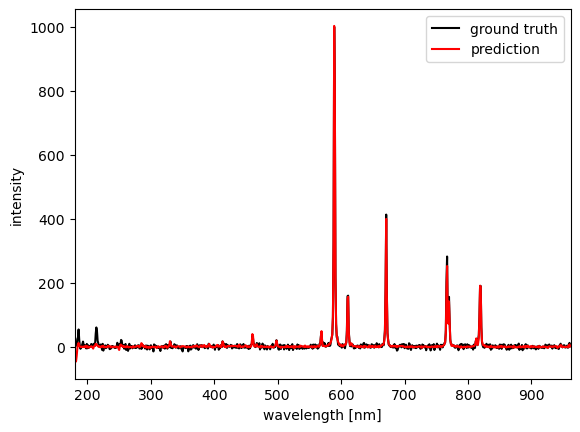

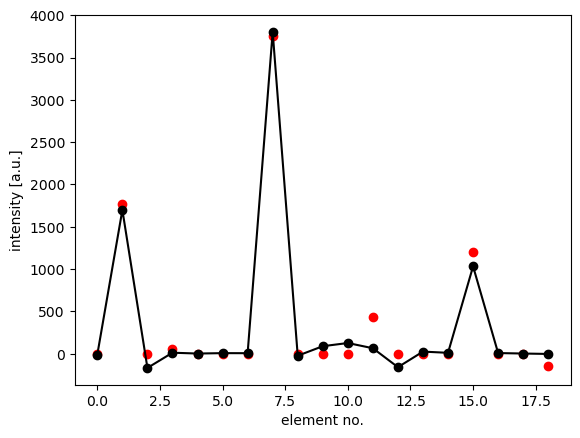

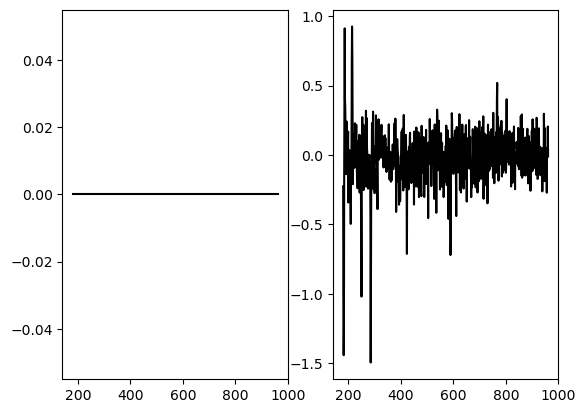

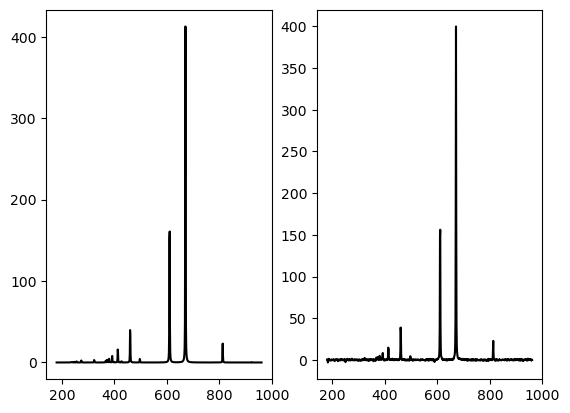

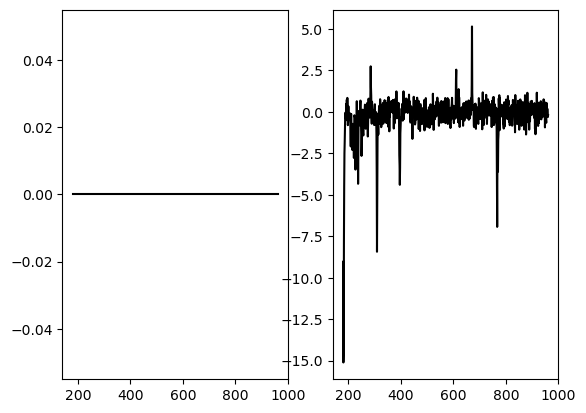

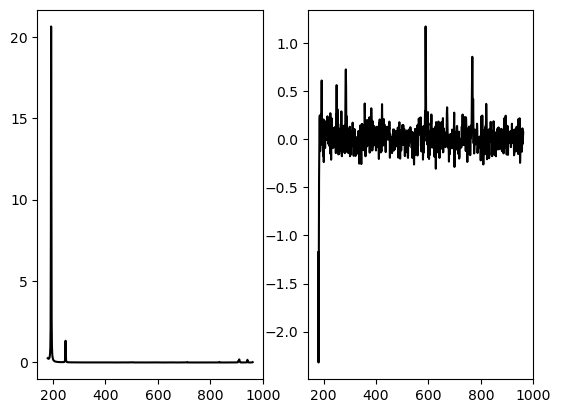

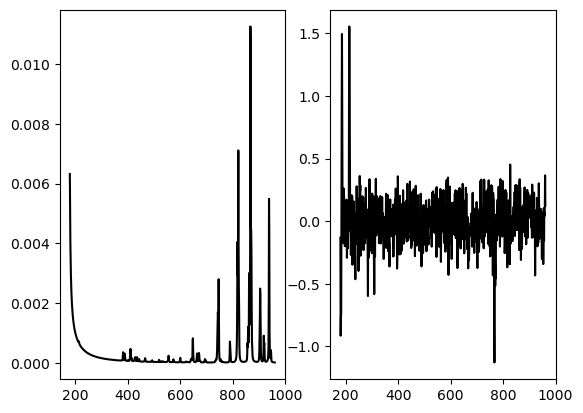

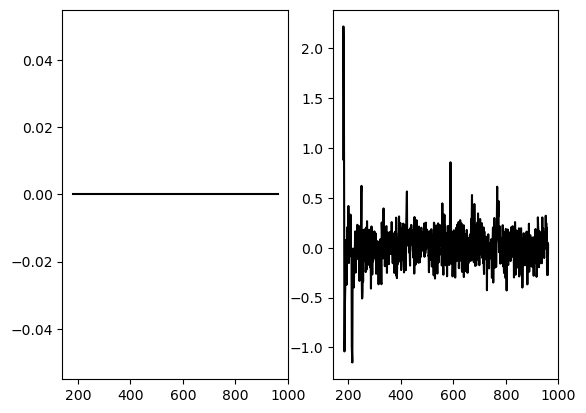

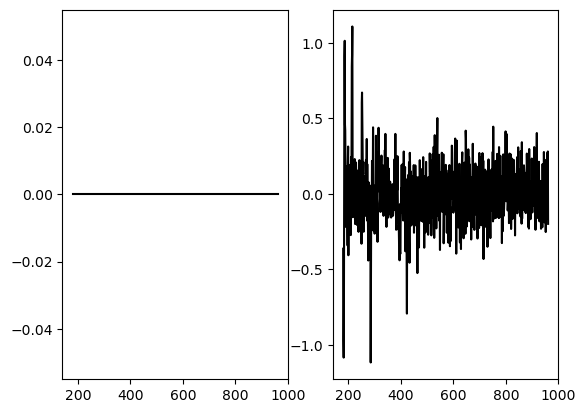

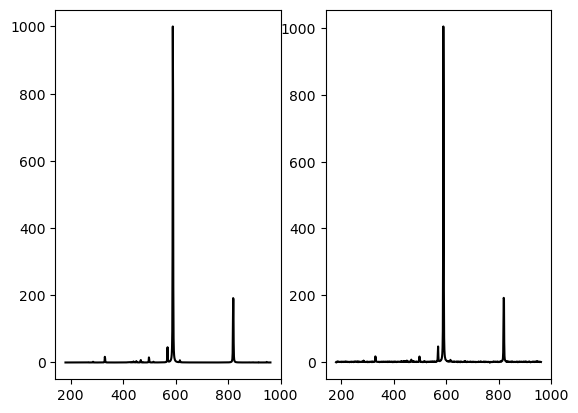

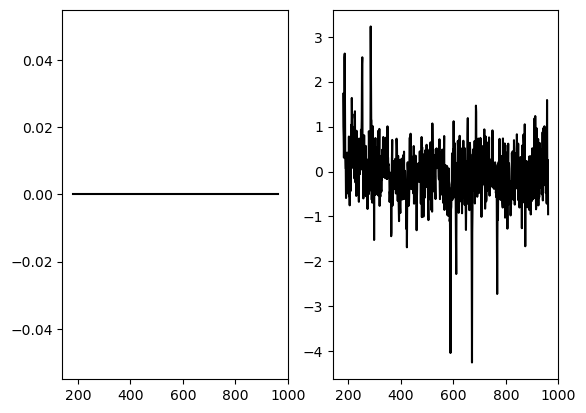

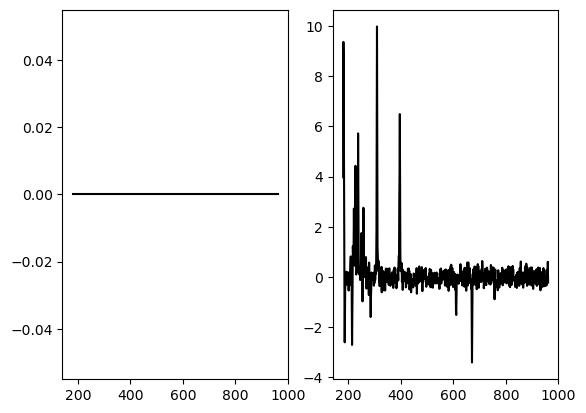

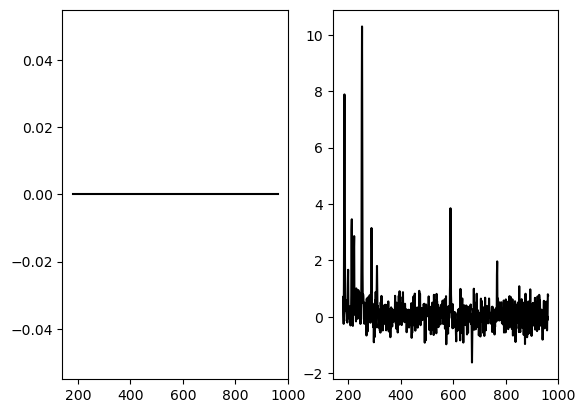

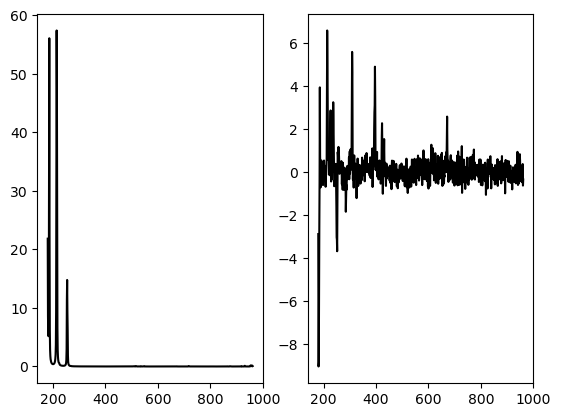

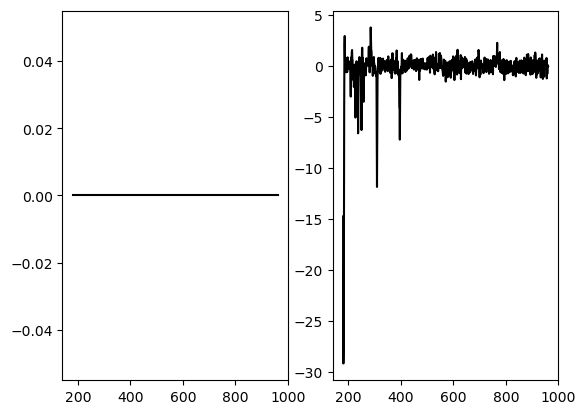

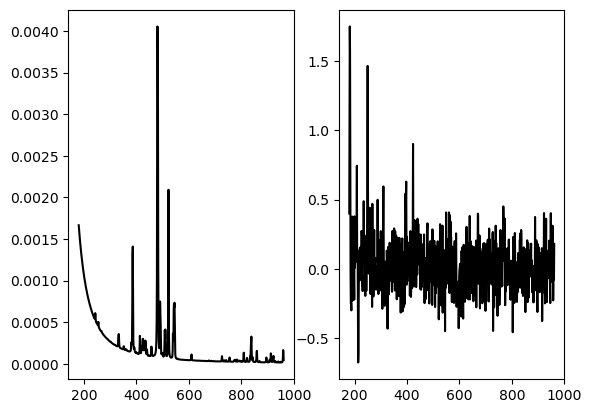

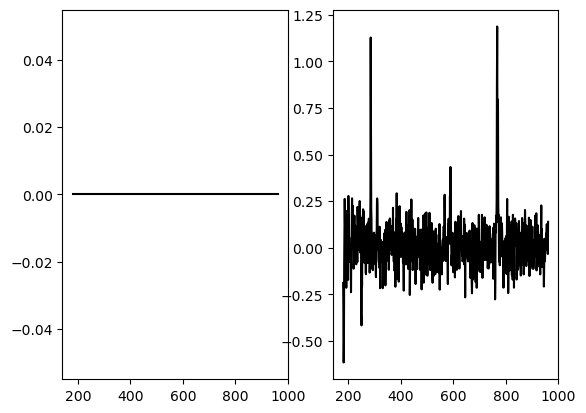

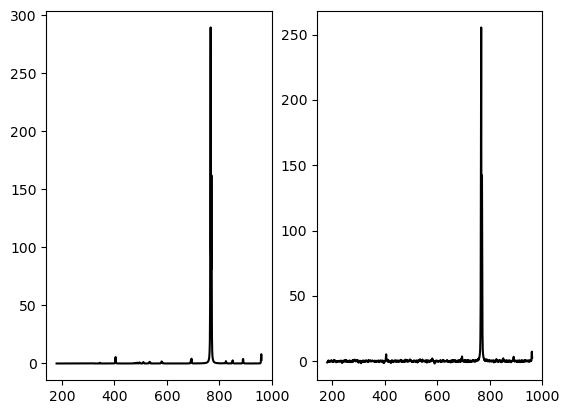

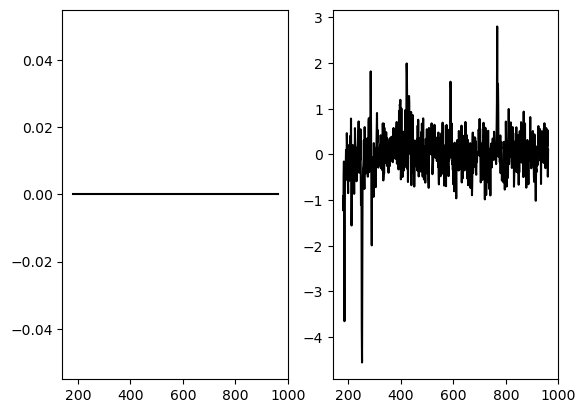

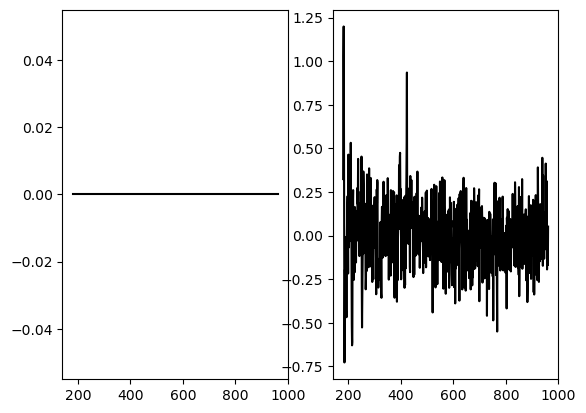

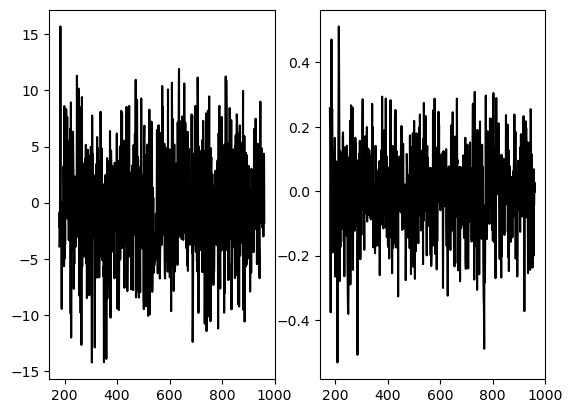

In [41]:
#prediction
max_z = y_data.shape[1] - 2
wl_points = len(wave) #number of wavelength point measurements in data
model = peakyfinder_0006.LIBSUNet(max_z, wl_points).cpu()
model.load_state_dict(torch.load(param_path))
model.eval() #.cpu()

#predicted vs. reference spectra
i_samp = 3 # vary up to max size of test/validation data
x_sample, y_sample = test_ds[i_samp]
x_sample = x_sample[None, ...].cpu()
y_sample = y_sample.cpu()
plot_thresh = 1

with torch.no_grad():
    pred = model(x_sample).cpu()
    y_pred = pred[0].cpu().detach().numpy()

    #first plot the composite input spectrum we're trying to decompose
    plt.plot(wave, x_sample[0][0], color='k', label='ground truth')
    plt.plot(wave, np.sum(y_pred, axis=0), color='r', label='prediction')
    plt.xlabel('wavelength [nm]')
    plt.ylabel('intensity')
    plt.xlim([180, 962])
    plt.legend()
    plt.show()
    
    plt.scatter(np.arange(len(y_sample)), np.sum(y_sample.detach().numpy(), axis=1), color='r', label='ground truth')
    plt.scatter(np.arange(len(y_pred)), np.sum(y_pred, axis=1), color='k', label='prediction')
    plt.plot(np.sum(y_pred, axis=1), color='k')
    plt.xlabel('element no.')
    plt.ylabel('intensity [a.u.]')
    plt.show()

    def pred_plot(ax, data1, data2, param_dict):
        out = ax.plot(data1, data2, **param_dict)
        return out
        
    for i in range(y_sample.shape[0]):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        #fig.suptitle(f'{elem_symb[i]} Input vs. Predicted ')
        pred_plot(ax1, wave, y_sample[i], {'color':'k', 'label':'ground truth'})
        pred_plot(ax2, wave, y_pred[i], {'color':'k', 'label':'ground truth'})
    plt.show()

# PeakyFitter (Spectrum Analyzer)

In [ ]:
def spec_fit():
        """
        """

### Survey NIST database to compare qualitative line intensities to physical properties
#### still under development

In [ ]:
def nist_analysis(self, col=3):
    """ This function is used to explore the NIST database
        still under development
    """
    # order of dict columns from the database:
    # ['sp_num', 'ritz_wl_vac(nm)', 'intens', 'gA(s^-1)', 'Ei(eV)', 'Ek(eV)','conf_i', 'term_i', 'J_i', 'conf_k', 'term_k', 'J_k', 'g_i', 'g_k'] # 14 total columns
    # NOTE: hydrogen has some highly degenrate states
    inten = []
    # ['Li','Na','K','Rb','Cs','Fr']
    # ['He', 'Be', 'Mg', 'Ca', 'Sr', 'Ba']
    # ['F', 'Cl', 'Br', 'I', 'Sr', 'Ba']
    # ['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr']
    # ['Y', 'Zr', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe']
    # ['La', 'Ce', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf']
    els = ['Ar']
    for e in els:
        inten.append(atom_dict[e][:,2])    
    gAs = []
    for e in els:
        gAs.append(atom_dict[e][:,col])

    inten = np.array([i for sub in inten for i in sub])
    gAs = np.array([i for sub in gAs for i in sub])
    notblank = np.invert(inten == '') # find rows with blank entries
    inten = inten[notblank].astype(float) # remove rows with blank entries
    gAs = gAs[notblank].astype(float) # remove rows where inten has blank entries
    isort = np.argsort(inten)
    
    plt.scatter(np.log10(gAs[isort][:]), np.log10(inten[isort][:]), s=0.1)
    plt.xlabel(r'$log_{10}$ gA $[s^{-1}]$')
    plt.ylabel(r'$log_{10}$ relative intensity [au]')
    plt.show()

/var/folders/yj/sjr_202x2fvfp9wq2lrrdf0h0000gn/T/ipykernel_60740/2062126807.py:56: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(gAs[isort][:]), np.log10(inten[isort][:]), s=0.1)


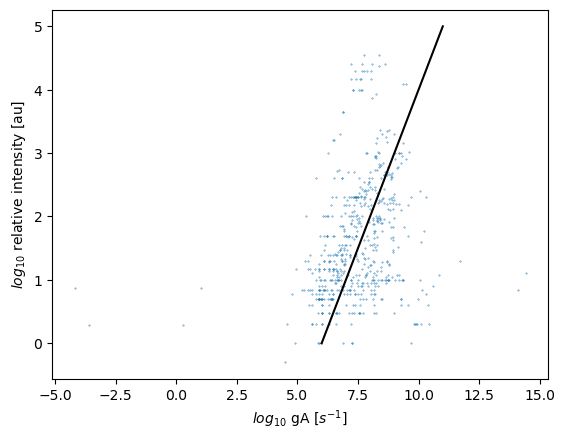

In [ ]:
# order of dict columns from the database: 0:'sp_num', 1:'ritz_wl_vac(nm)', 2:'intens', 3:'gA(s^-1)', 4:'Ei(eV)', 5:'Ek(eV)', 6: 'g_i', 7:'g_k'
# plt.scatter(np.linspace(0,9,100), 1.2*np.linspace(0,9,100), s=5)
# plt.scatter(np.linspace(0,8,100), 1.4*np.linspace(0,8,100), s=5)
# plt.scatter(np.linspace(0,7,100), 1.6*np.linspace(0,7,100), s=5)
# plt.scatter(np.linspace(0,6,100), 1.8*np.linspace(0,6,100), s=5)
# plt.scatter(np.linspace(0,5.5,100), 2*np.linspace(0,5.5,100), s=5)
# plt.scatter(np.linspace(0,5,100), 2.2*np.linspace(0,5,100), s=5)
plt.plot(np.linspace(6,11,100), np.linspace(6,11,100) - 6, color='k')
test_maker.nist_analysis(col=3)
